# Variación de Propiedades Nucleares: Modelo de Materia de Estrellas de Neutrones

In [2]:
# Importamos las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

import sys
import pathlib
scripts_path = pathlib.Path().cwd() / 'scripts' # Aseguramos que el directorio de scripts esté en el path
sys.path.append(str(scripts_path))

# Importamos nuestros módulos

import scripts.ResolverTOV as tov
import scripts.NSMatterEoS as nsEoS
from scripts.NSMatterEoS import m_nuc_MKS, m_nuc, MeVfm_to_Jm, MeV_to_fm11
from scripts.Optimizar_IsospinEoS import (
    optimizar_parametros, 
    crear_propiedades_objetivo,
    estudiar_parametros_vs_propiedades,
    plot_convergencia_optimizacion,
    plot_parametros_vs_propiedad
 )

## 1. Optimización de Parámetros del Modelo $\sigma^4$-$\omega$-$\mathbf{\rho}$

Primero, vamos a optimizar los parámetros del modelo para ajustar las propiedades de saturación nuclear.

In [3]:
# Crear propiedades objetivo con valores experimentales
props_experimentales = crear_propiedades_objetivo(
    n_sat=0.161,    # fm^-3
    B_A_sat=-16.24, # MeV  
    K_mod=230.0,    # MeV
    a_sym=31.6      # MeV
)

# Optimizar parámetros usando el método de mínimos cuadrados
resultados_ls = optimizar_parametros(
    props_experimentales,
    metodo='leastsq',
    verbose=True
)

Iniciando optimización con método: leastsq
Parámetros iniciales:
  A_sigma: 287.1702
  A_omega: 161.8332
  A_rho: 99.8439
  b: 0.0056
  c: -0.0070

No se encontró solución para n_barion =  0.11233240329780265
No se encontró solución para n_barion =  0.1201705308880486
No se encontró solución para n_barion =  0.1285555731913902
No se encontró solución para n_barion =  0.13752569183507288
No se encontró solución para n_barion =  0.1471217112194568
No se encontró solución para n_barion =  0.15738730431619027
No se encontró solución para n_barion =  0.1683691914306742
No se encontró solución para n_barion =  0.1801173528334133
No se encontró solución para n_barion =  0.19268525622797403
No se encontró solución para n_barion =  0.20613010009079216
No se encontró solución para n_barion =  0.22051307399030456
No se encontró solución para n_barion =  0.23589963707015932
No se encontró solución para n_barion =  0.25235981596392615
No se encontró solución para n_barion =  0.26996852349715966
No 

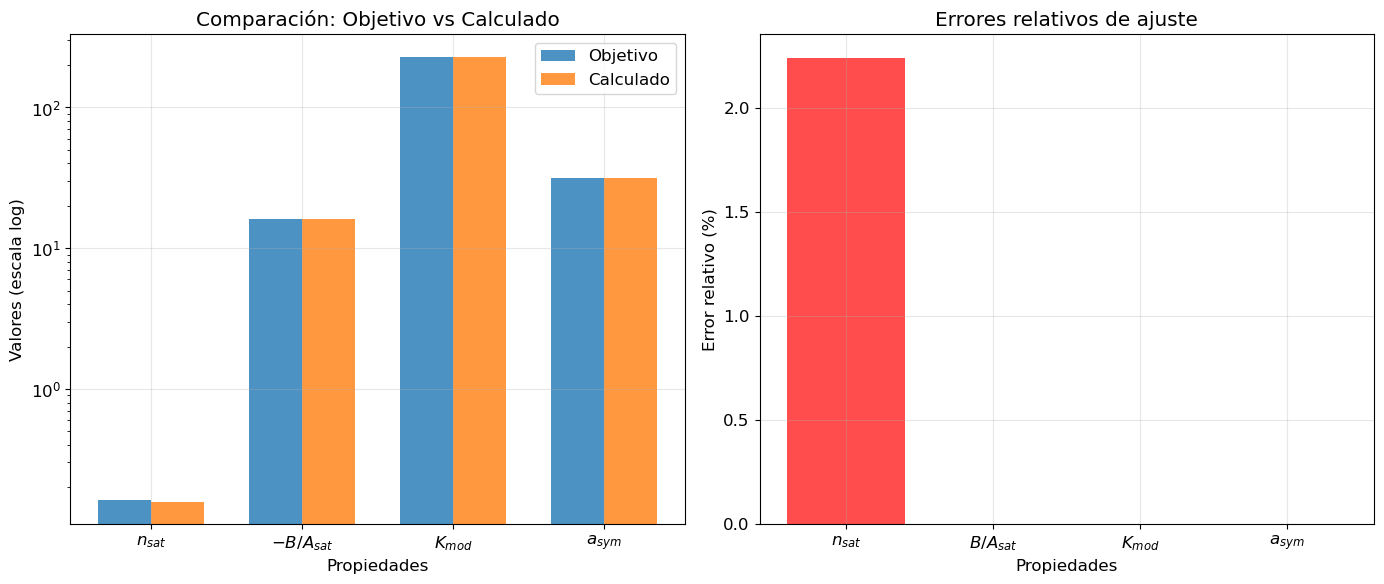

In [3]:
# Visualizar los resultados de la optimización
plot_convergencia_optimizacion(resultados_ls)

## 2. Comparación de Métodos de Optimización

Vamos a comparar diferentes métodos de optimización para ver cuál funciona mejor.

In [4]:
# Probar diferentes métodos de optimización
metodos = ['leastsq', 'least_squares', 'nelder', 'differential_evolution']
resultados_metodos = {}

for metodo in metodos:
    print(f"\n=== OPTIMIZACIÓN CON {metodo.upper()} ===")

    if metodo == 'differential_evolution':
        # Para differential evolution, podemos especificar más opciones para no demorar tanto
        resultado = optimizar_parametros(
            props_experimentales,
            metodo=metodo,
            max_nfev=1000,  # Máximo número de iteraciones
            popsize=15,   # Tamaño de población
            verbose=False
        )
    else:
        # Para otros métodos de lmfit usamos configuración por defecto
        resultado = optimizar_parametros(
            props_experimentales,
            metodo=metodo,
            verbose=False
        )

    resultados_metodos[metodo] = resultado


=== OPTIMIZACIÓN CON LEASTSQ ===

=== OPTIMIZACIÓN CON LEAST_SQUARES ===

=== OPTIMIZACIÓN CON NELDER ===

=== OPTIMIZACIÓN CON DIFFERENTIAL_EVOLUTION ===


In [5]:
# Comparar los resultados de los diferentes métodos
print("\n=== COMPARACIÓN DE MÉTODOS ===")
print(f"{'Método':<22} {'Chi²':<12} {'Éxito':<8} {'n_sat error (%)':<15}")
print("-" * 60)

for metodo, resultado in resultados_metodos.items():
    if resultado['propiedades_calculadas']:
        chi2 = resultado['chi2_final']
        exito = "Sí" if resultado['exito'] else "No"
        
        # Calcular error en n_sat como ejemplo
        n_sat_obj = resultado['propiedades_objetivo']['n_sat']
        n_sat_calc = resultado['propiedades_calculadas']['n_sat']
        error_nsat = 100 * abs(n_sat_calc - n_sat_obj) / n_sat_obj
        
        print(f"{metodo:<22} {chi2:<12.6f} {exito:<8} {error_nsat:<15.2f}")
    else:
        print(f"{metodo:<22} {'FALLÓ':<12} {'No':<8} {'-':<15}")


=== COMPARACIÓN DE MÉTODOS ===
Método                 Chi²         Éxito    n_sat error (%)
------------------------------------------------------------
leastsq                0.001007     Sí       2.24           
least_squares          0.011034     Sí       2.24           
nelder                 0.001007     Sí       2.24           
differential_evolution 7.958535     No       99.38          


## 3. Dependencia de Parámetros con Propiedades de Saturación

Ahora estudiaremos cómo cambian los parámetros optimizados cuando variamos cada una de las propiedades de saturación.

In [6]:
# Definir rangos de variación para cada propiedad
variaciones = {
    'n_sat': np.linspace(0.14, 0.18, 8),     # Densidad de saturación
    'B_A_sat': np.linspace(-18, -14, 8),     # Energía de enlace 
    'K_mod': np.linspace(200, 260, 8),       # Módulo de compresión
    'a_sym': np.linspace(29, 35, 8)          # Coeficiente de simetría
}

# Realizar estudio paramétrico
print("Iniciando estudio paramétrico...")
print("(Esto puede tomar varios minutos dependiendo de los rangos)")

resultados_estudio = estudiar_parametros_vs_propiedades(
    props_experimentales,
    variaciones,
    metodo='leastsq'  # Usamos el método más eficiente
)

print("\nEstudio paramétrico completado!")

Iniciando estudio paramétrico...
(Esto puede tomar varios minutos dependiendo de los rangos)

Estudiando variación de n_sat...

Estudiando variación de B_A_sat...

Estudiando variación de K_mod...

Estudiando variación de a_sym...

Estudio paramétrico completado!



Graficando variación de parámetros vs n_sat


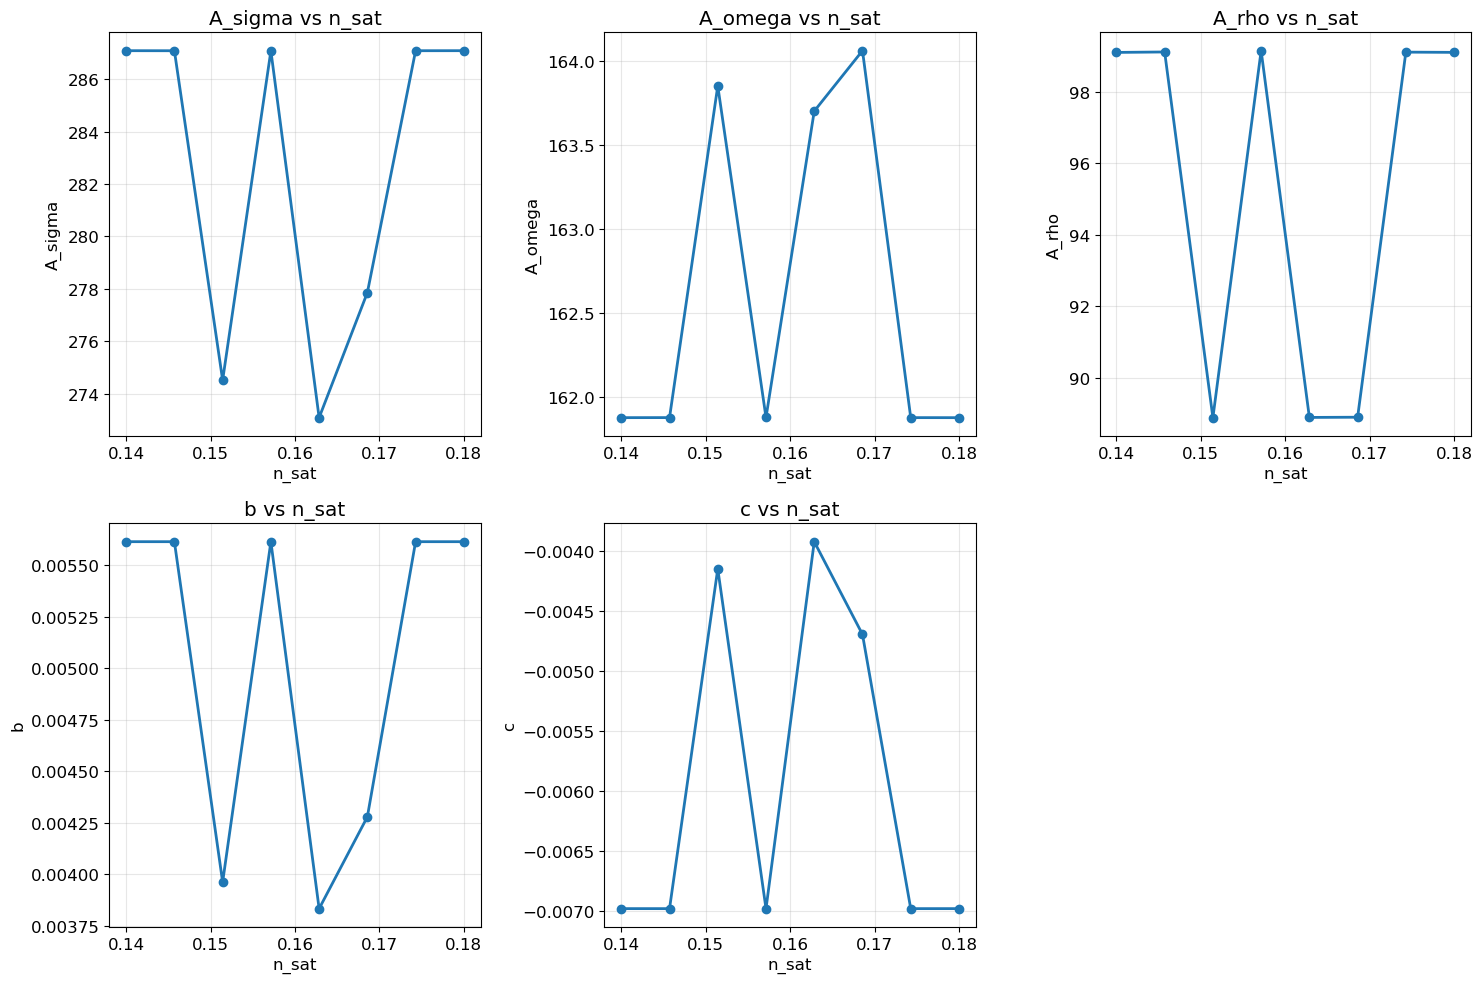


Graficando variación de parámetros vs B_A_sat


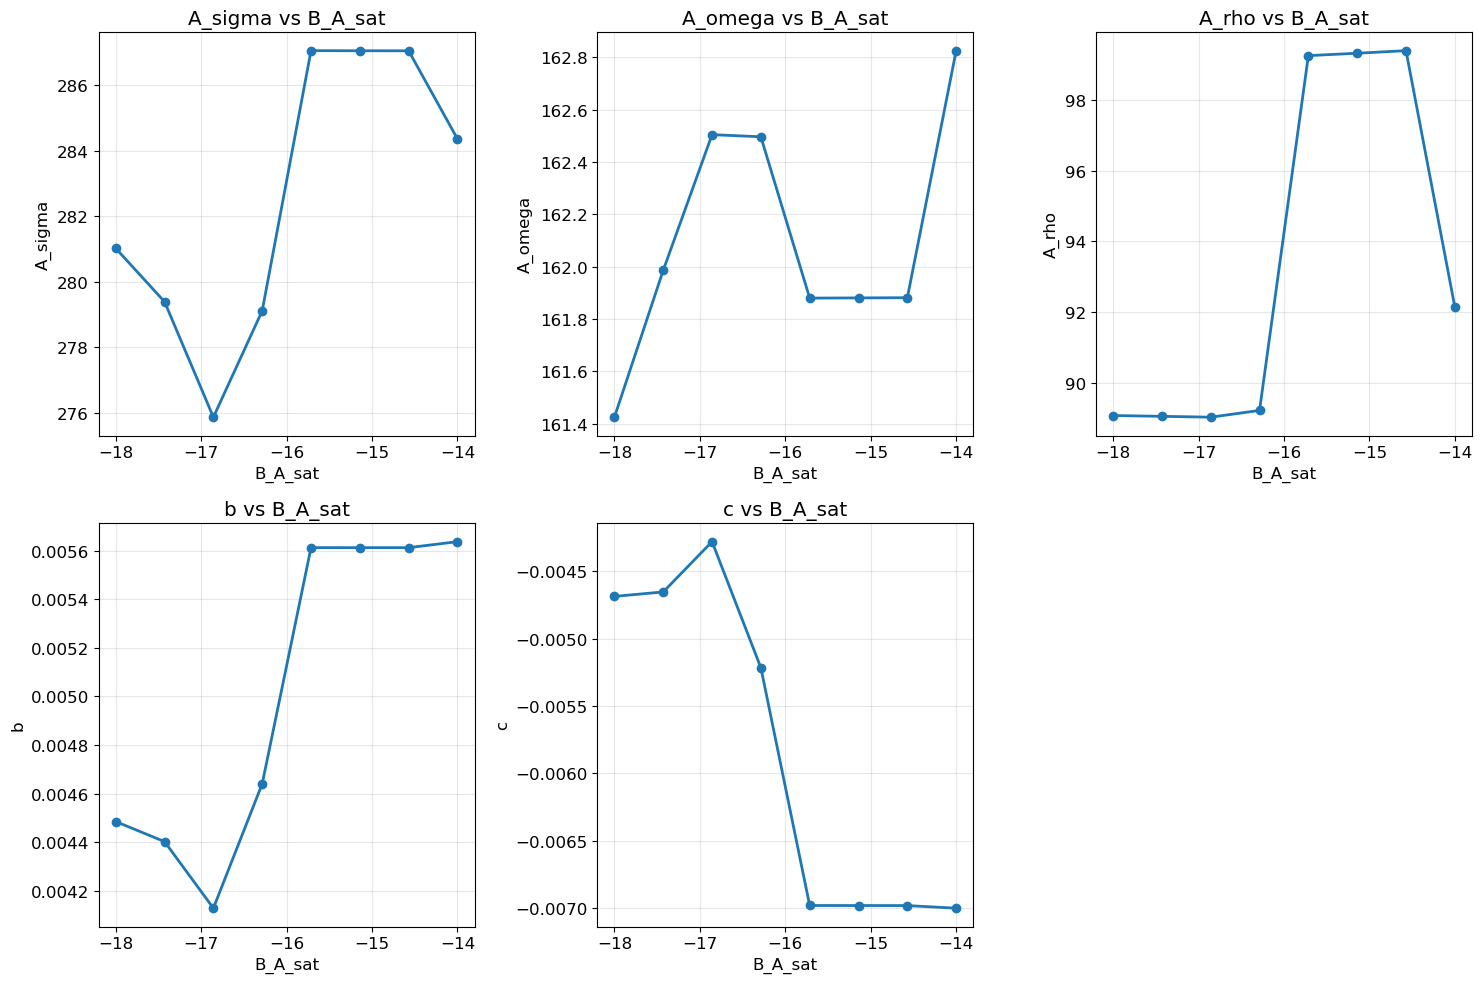


Graficando variación de parámetros vs K_mod


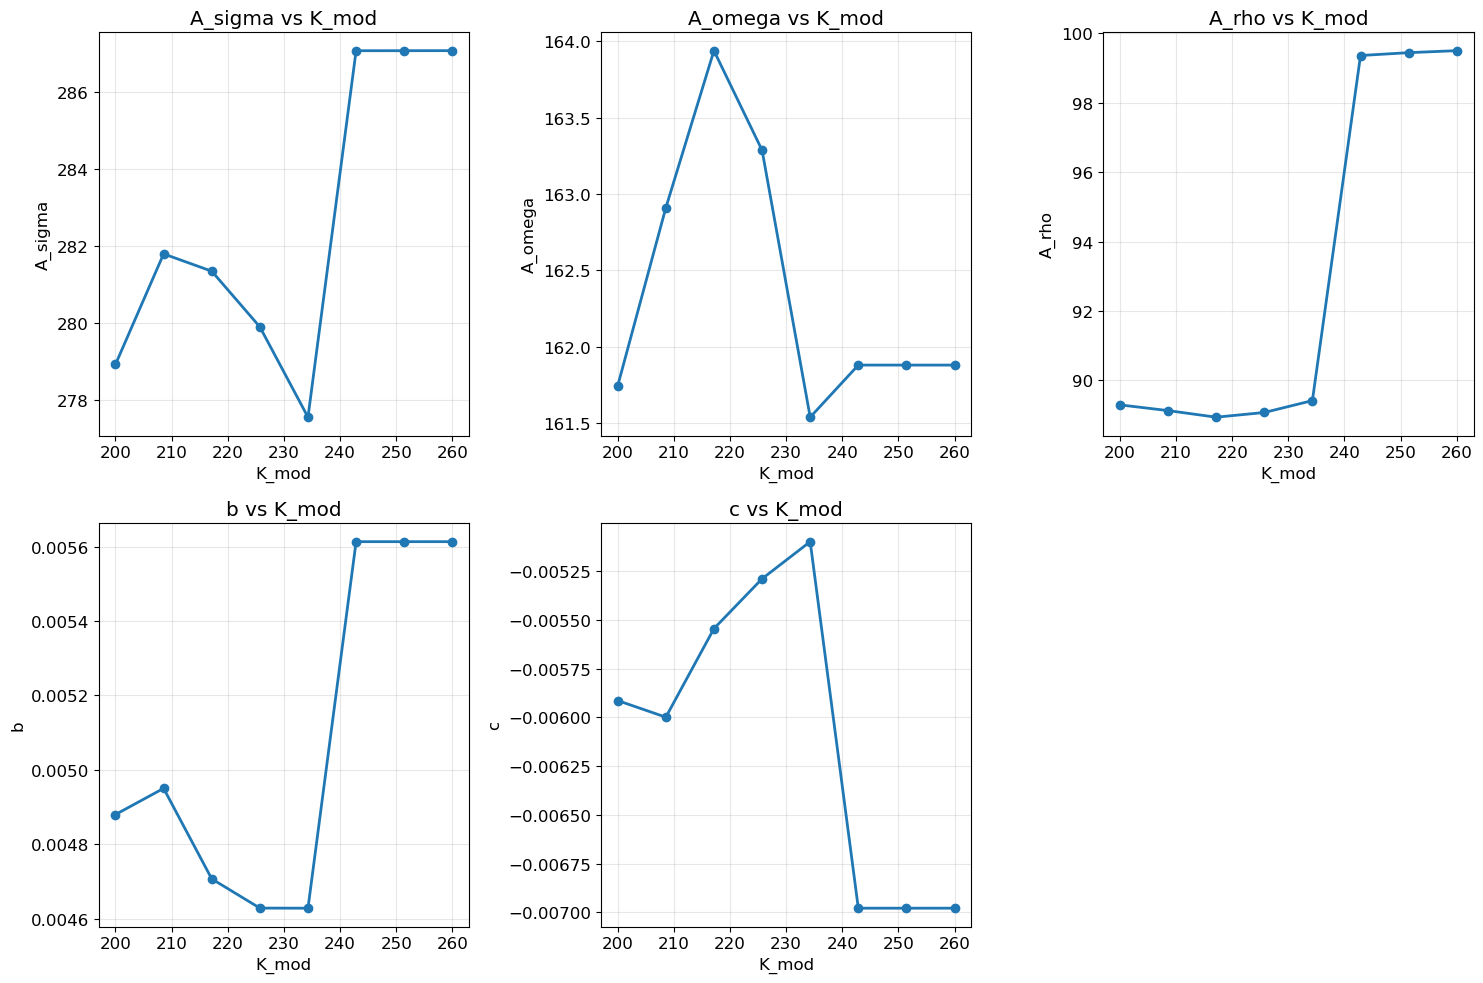


Graficando variación de parámetros vs a_sym


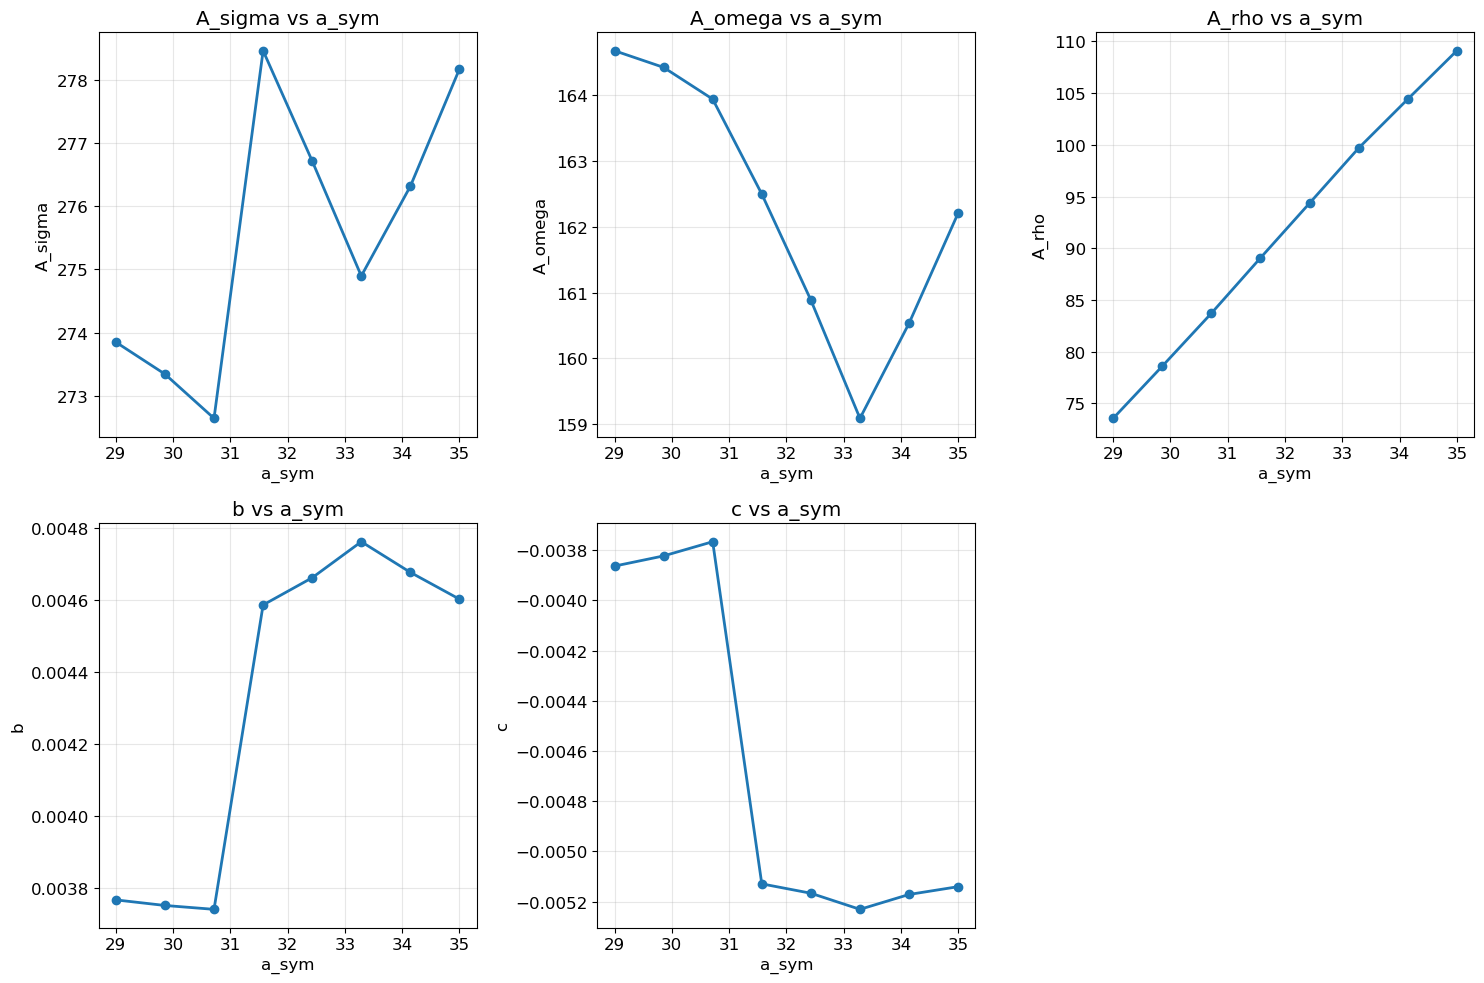

In [7]:
# Visualizar cómo varían los parámetros con cada propiedad
for propiedad in variaciones.keys():
    print(f"\nGraficando variación de parámetros vs {propiedad}")
    plot_parametros_vs_propiedad(resultados_estudio, propiedad)

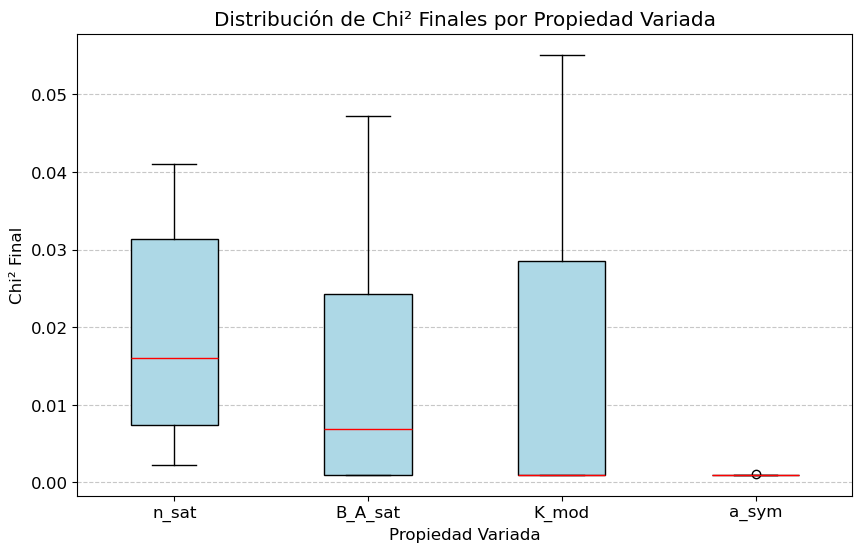

In [10]:
# Boxplot de la distribución de Chi² finales por propiedad variada
chi2_por_prop = [
    [res['chi2'] for res in resultados]
    for resultados in resultados_estudio.values()
]
labels = list(resultados_estudio.keys())

plt.figure(figsize=(10, 6))
plt.boxplot(
    chi2_por_prop,
    tick_labels=labels,
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', edgecolor='black'),
    medianprops=dict(color='red')
)
plt.title('Distribución de Chi² Finales por Propiedad Variada')
plt.xlabel('Propiedad Variada')
plt.ylabel('Chi² Final')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 4. Estudio Masa-Radio para Diferentes Propiedades

Finalmente, vamos a estudiar cómo afectan las variaciones en las propiedades de saturación a la relación masa-radio de las estrellas de neutrones.

In [5]:
def calcular_masa_radio_optimizado(propiedades_objetivo, metodo='leastsq', fixed_params=[]):
    """
    Calcula la relación masa-radio optimizando primero los parámetros
    para las propiedades objetivo dadas.
    """
    # Optimizar parámetros
    resultado_opt = optimizar_parametros(
        propiedades_objetivo,
        metodo=metodo,
        verbose=False,
        fixed_params=fixed_params
    )
    if not resultado_opt['exito']:
        return None, None, None
    
    # Extraer parámetros optimizados
    params_opt = resultado_opt['parametros_optimizados'].values()
    print(f"Propiedades calculadas: {resultado_opt['propiedades_calculadas']}")
    print(f"Parámetros optimizados: {params_opt}")
    
    # Construir EoS con NSMatterEoS
    densidad_max = 1e18*1e3*(1e-45/m_nuc_MKS) # g/cm^3 a fm^-3
    densidad_min = 1e12*1e3*(1e-45/m_nuc_MKS)
    n_range = np.logspace(np.log10(densidad_min), np.log10(densidad_max), 200)
    rho_P, presiones, energias, n_sirve, _ = nsEoS.EoS(n_range, params_opt, add_crust=True, crust_file_path='EoS_tables/EoS_crust.txt')
    densidad_limite = energias[0] # Densidad mínima de la EoS
    P_rho = CubicSpline(energias, presiones)

    # Definir densidades centrales de masa (g/cm^3)
    rhos_masa = np.logspace(np.log10(n_sirve[1]*1e45*m_nuc_MKS*1e-3), 18, 150)
    masas = np.zeros(len(rhos_masa))
    radios = np.zeros(len(rhos_masa))

    # Loop TOV para cada densidad central
    for i, rho_m in enumerate(rhos_masa):
        # Convertir densidad de masa a bariónica (fm^-3)
        n_bar = rho_m * 1e3 / m_nuc_MKS * 1e-45
        # Obtener densidad de energía adimensional
        rho0_dim, _ = nsEoS.energia_presion(n_bar, params_opt)
        # Preparar función rho(P) adimensionalizada
        R = 1.0 / rho0_dim
        rho_P_prima = lambda P: R * rho_P(P / R)
        P_central_prima = R * P_rho(1/R)
        dens_lim_prima = R * densidad_limite
        
        # Integrar TOV
        rho_nat_to_MKS = 1.0 / MeV_to_fm11 * MeVfm_to_Jm
        sol = tov.integrador(rf=1.0, dr=1e-3, rho0=rho0_dim*m_nuc**4/2*rho_nat_to_MKS, rho_P=rho_P_prima,
                           P_central=P_central_prima, densidad_limite=dens_lim_prima)
        r_phys, m_phys, _, _, _ = sol
        radios[i] = r_phys * 1e-3  # en km
        masas[i] = m_phys / 1.989e30  # en M_sun

    return masas, radios, rhos_masa

Calculando masa-radio para a_sym = 29.000 fm^-3 o MeV ...
Propiedades calculadas: {'n_sat': np.float64(0.15738730431619027), 'B_A_sat': np.float64(-16.23988882149137), 'K_mod': np.float64(229.99828607987774), 'a_sym': np.float64(28.999908118952497)}
Parámetros optimizados: dict_values([np.float64(273.8497503298314), np.float64(164.67781470443234), np.float64(73.5378402536992), np.float64(0.0037673294854928957), np.float64(-0.0038635084046269013)])
Calculando masa-radio para a_sym = 30.500 fm^-3 o MeV ...
Propiedades calculadas: {'n_sat': np.float64(0.15738730431619027), 'B_A_sat': np.float64(-16.26417404789133), 'K_mod': np.float64(230.60572891342102), 'a_sym': np.float64(30.504412700265615)}
Parámetros optimizados: dict_values([np.float64(272.86793817426104), np.float64(164.09240824320045), np.float64(82.41185276112115), np.float64(0.0037417628823481763), np.float64(-0.003777834448485634)])
Calculando masa-radio para a_sym = 32.000 fm^-3 o MeV ...
Propiedades calculadas: {'n_sat': np.

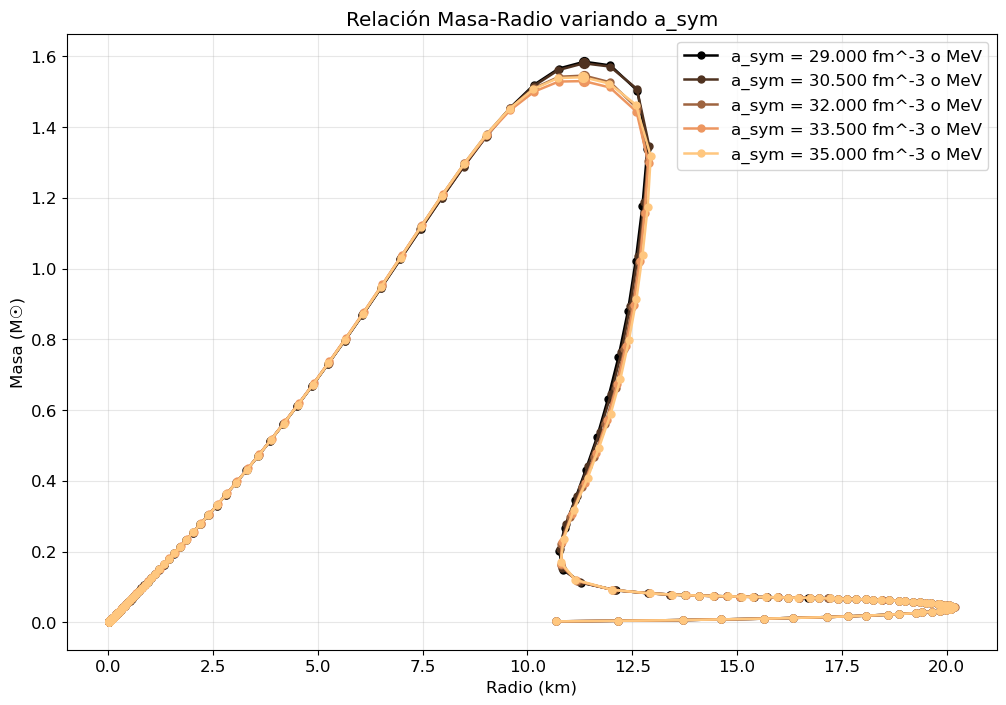

In [8]:
# Calcular masa-radio para diferentes valores de una propiedad específica

propiedad_estudio = 'a_sym'
valores_prop = np.linspace(29, 35, 5)

plt.figure(figsize=(12, 8))

colores = plt.cm.copper(np.linspace(0, 1, len(valores_prop)))

for i, prop_val in enumerate(valores_prop):
    print(f"Calculando masa-radio para {propiedad_estudio} = {prop_val:.3f} fm^-3 o MeV ...")
    
    # Crear propiedades objetivo con propiedad variable
    props_temp = props_experimentales.copy()
    props_temp[propiedad_estudio] = prop_val
    
    # Calcular masa-radio
    masas, radios, n_centrales = calcular_masa_radio_optimizado(props_temp)
    
    if masas is not None and radios is not None:
        plt.plot(radios, masas, "o-", color=colores[i], linewidth=1.8, markersize=5, 
                label=f'{propiedad_estudio} = {prop_val:.3f} fm^-3 o MeV')
        
        # Marcar la masa máxima
        masa_max_idx = np.argmax(masas)
        plt.scatter(radios[masa_max_idx], masas[masa_max_idx], 
                   color=colores[i], s=50, marker='o', zorder=5)
    else:
        print(f"  Falló el cálculo para {propiedad_estudio} = {prop_val}")

plt.xlabel('Radio (km)')
plt.ylabel('Masa (M☉)')
plt.title(f'Relación Masa-Radio variando {propiedad_estudio}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()


===== ESTUDIO PARA: N_SAT =====
  Calculando para n_sat = 0.140...
Propiedades calculadas: {'n_sat': np.float64(0.15738730431619027), 'B_A_sat': np.float64(-16.19869155157398), 'K_mod': np.float64(219.67670002584472), 'a_sym': np.float64(33.2542868391705)}
Parámetros optimizados: dict_values([np.float64(287.0814527722155), np.float64(161.8778201428852), np.float64(99.10512910729373), np.float64(0.005613263273934353), np.float64(-0.006978433656680211)])


c:\Users\nicom\Desktop\CalculosSimulaciones\NS_Structure\scripts\NSMatterEoS.py:60: RuntimeWarning: invalid value encountered in scalar power
  x_pF = ( (3.0*pi**2)*n_barion/m_nuc**3 - x_nF**3)**(1/3) # Momento de Fermi del protón (y electrón)
c:\Users\nicom\Desktop\CalculosSimulaciones\NS_Structure\scripts\ResolverTOV.py:163: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = odeint(ecuaciones, [P0, m0, phi0], r, args=(rho_P,)).T
c:\Users\nicom\Desktop\CalculosSimulaciones\NS_Structure\scripts\ResolverTOV.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  dP_dr = -m*rho/r**2*(1+P/rho)*(1+r**3*P/m)/(1-2*m/r)
c:\Users\nicom\Desktop\CalculosSimulaciones\NS_Structure\scripts\ResolverTOV.py:163: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  sol = odeint(ecuaciones, [P0, m0, phi0], r, args=(rho_P,)).T
c:\User

  Calculando para n_sat = 0.146...
Propiedades calculadas: {'n_sat': np.float64(0.15738730431619027), 'B_A_sat': np.float64(-16.19811391779477), 'K_mod': np.float64(219.66702180552247), 'a_sym': np.float64(33.25646713215122)}
Parámetros optimizados: dict_values([np.float64(287.07936077371085), np.float64(161.87815358816792), np.float64(99.11785612007894), np.float64(0.005613224576927008), np.float64(-0.00697855971412909)])
  Calculando para n_sat = 0.151...
Propiedades calculadas: {'n_sat': np.float64(0.15738730431619027), 'B_A_sat': np.float64(-16.239904111131835), 'K_mod': np.float64(229.99798462923994), 'a_sym': np.float64(31.59995752562726)}
Parámetros optimizados: dict_values([np.float64(274.5175470314314), np.float64(163.85198212631664), np.float64(88.8825345478933), np.float64(0.003962806567612484), np.float64(-0.004145800742970361)])
  Calculando para n_sat = 0.157...
Propiedades calculadas: {'n_sat': np.float64(0.15738730431619027), 'B_A_sat': np.float64(-16.19708663499175), '

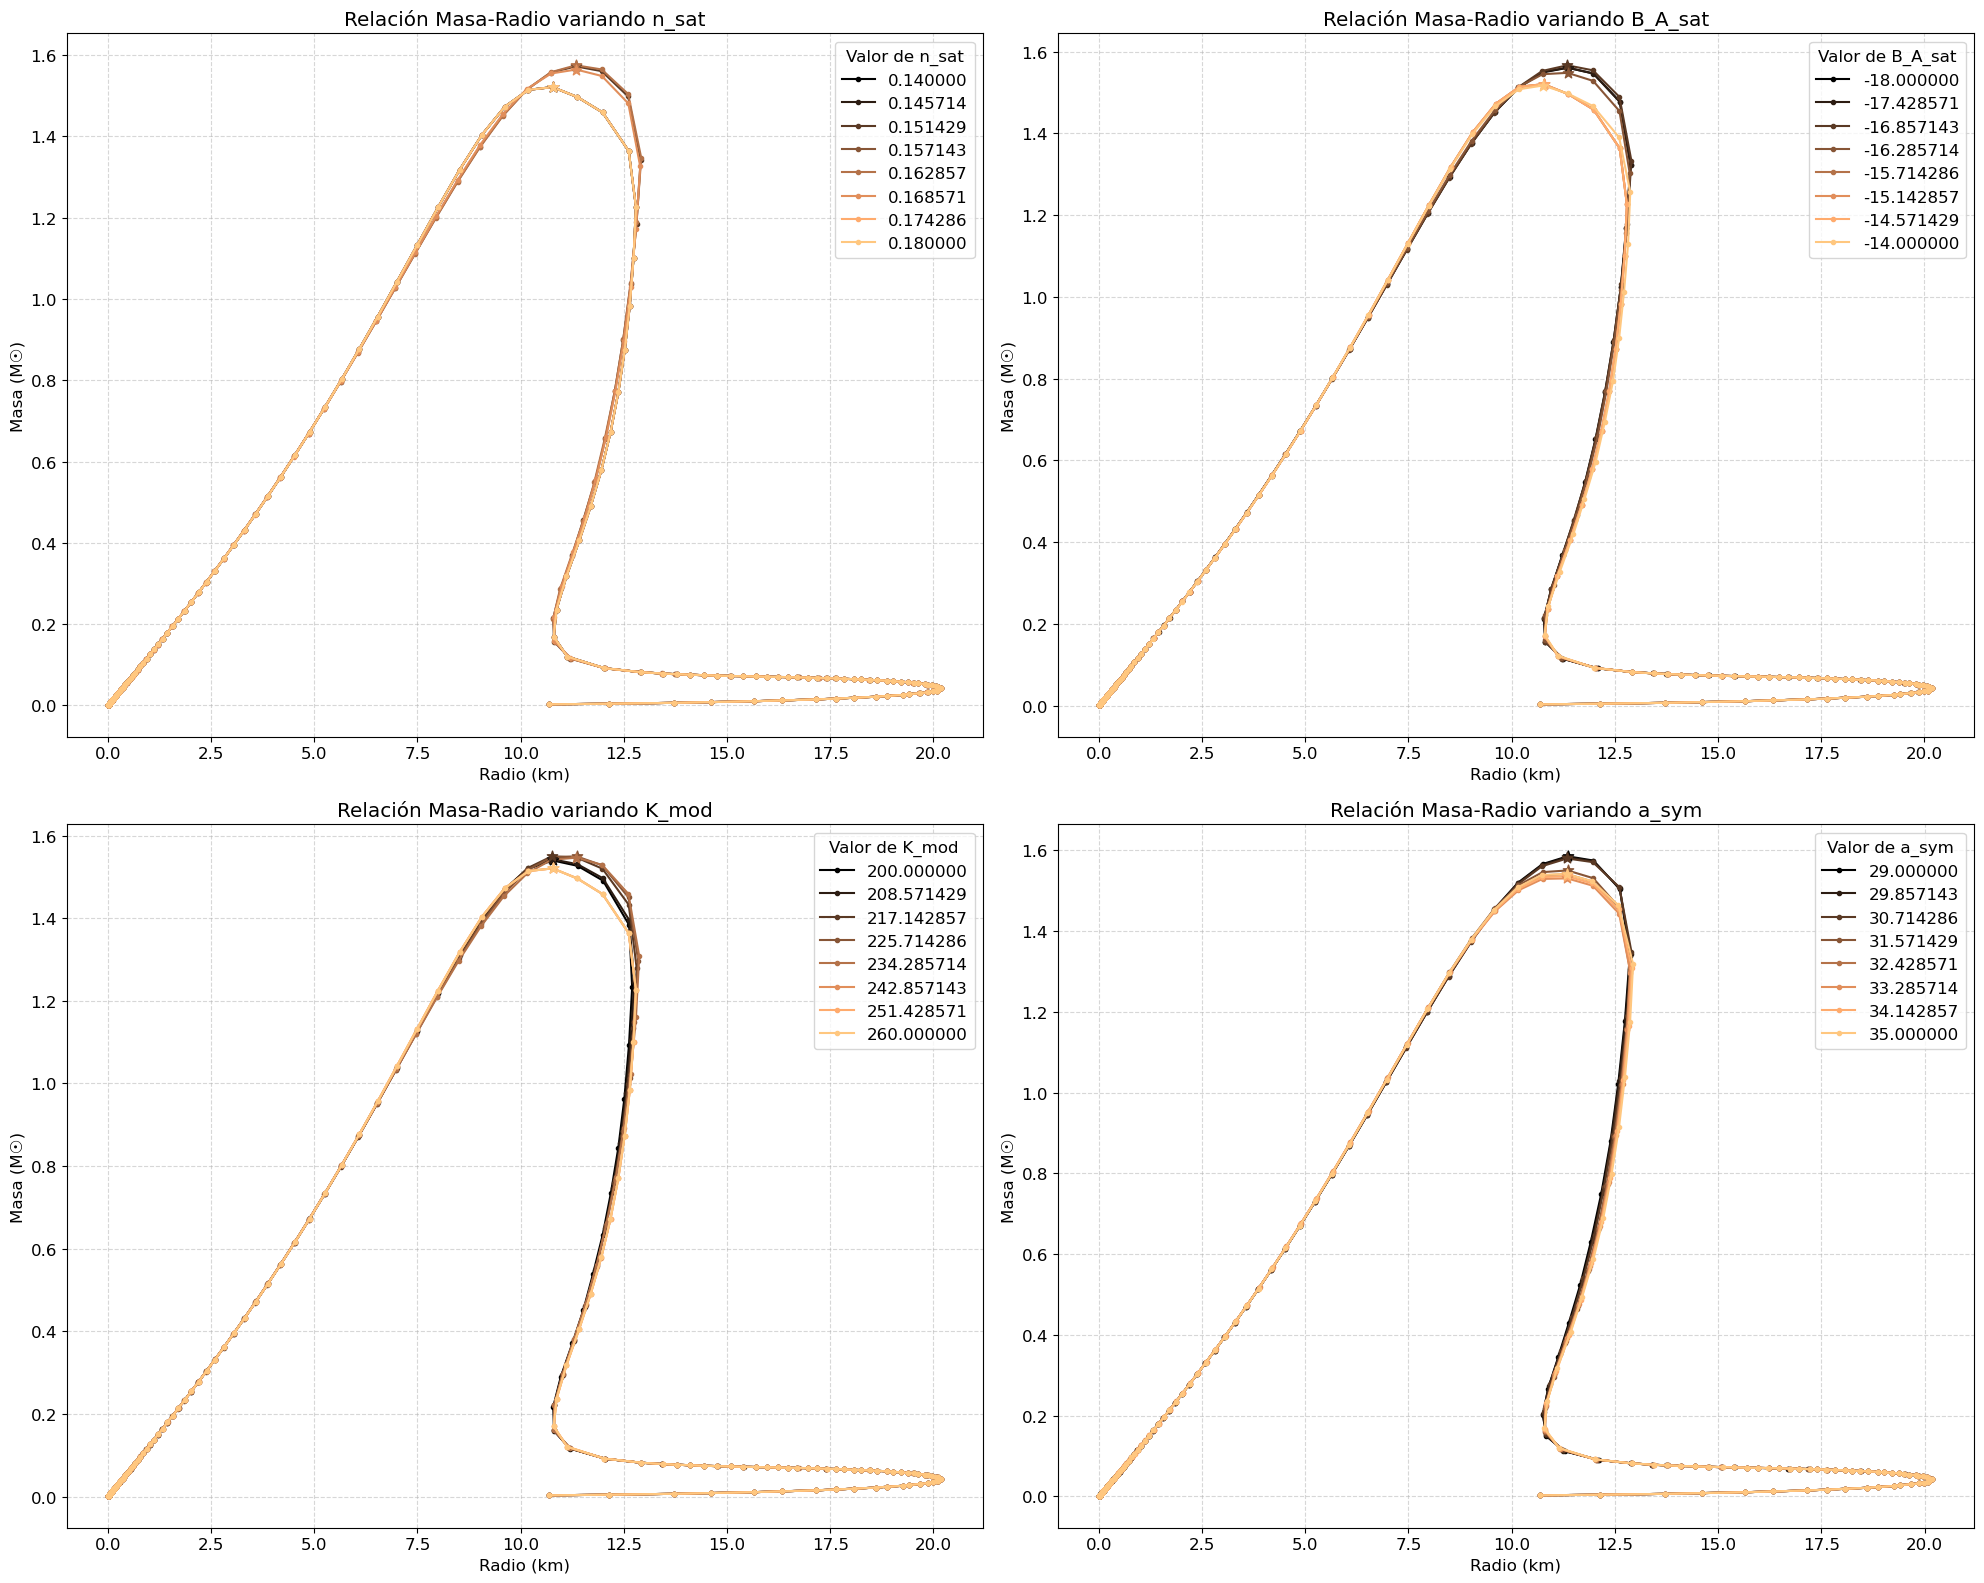

In [33]:
# Definir rangos de variación para cada propiedad
variaciones = {
    'n_sat': np.linspace(0.14, 0.18, 8),     # Densidad de saturación
    'B_A_sat': np.linspace(-18, -14, 8),     # Energía de enlace 
    'K_mod': np.linspace(200, 260, 8),       # Módulo de compresión
    'a_sym': np.linspace(29, 35, 8)          # Coeficiente de simetría
}

# Crear una figura con 4 subplots (2x2)
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()  # Aplanar el array de ejes para iterar fácilmente

# Iterar sobre cada propiedad y su rango de variación
for idx, (propiedad, valores) in enumerate(variaciones.items()):
    ax = axes[idx]
    colores = plt.cm.copper(np.linspace(0, 1, len(valores)))
    
    print(f"\n===== ESTUDIO PARA: {propiedad.upper()} =====")
    
    # Iterar sobre cada valor de la propiedad
    for i, valor in enumerate(valores):
        print(f"  Calculando para {propiedad} = {valor:.3f}...")
        
        # Crear propiedades objetivo temporales
        props_temp = props_experimentales.copy()
        props_temp[propiedad] = valor
        
        # Calcular la relación masa-radio
        masas, radios, _ = calcular_masa_radio_optimizado(props_temp)
        
        if masas is not None and radios is not None:
            # Graficar la curva M-R
            ax.plot(radios, masas, "o-", color=colores[i], linewidth=1.5, markersize=3, 
                    label=f'{valor:3f}')
            
            # Marcar la masa máxima
            masa_max_idx = np.argmax(masas)
            ax.scatter(radios[masa_max_idx], masas[masa_max_idx], 
                       color=colores[i], s=60, marker='*', zorder=5)
        else:
            print(f"    Cálculo fallido para {propiedad} = {valor}")

    # Configurar el subplot
    ax.set_xlabel('Radio (km)')
    ax.set_ylabel('Masa (M☉)')
    ax.set_title(f'Relación Masa-Radio variando {propiedad}')
    ax.legend(title=f'Valor de {propiedad}')
    ax.grid(True, linestyle='--', alpha=0.5)

# Ajustar el layout y mostrar la figura
plt.tight_layout()
plt.show()

## 5. Fijación de Parámetros

Vamos a fijar algunos parámetros del modelo para ver cómo afecta esto a las propiedades de saturación y a la relación masa-radio.

Calculando para a_sym = 29.000 con 'b' fijado...
Propiedades calculadas: {'n_sat': np.float64(0.1683691914306742), 'B_A_sat': np.float64(-16.239881196076887), 'K_mod': np.float64(229.99784284291678), 'a_sym': np.float64(28.99997663680184)}
Parámetros optimizados: dict_values([np.float64(236.99992115116595), np.float64(131.25220986722059), np.float64(68.9261701728072), 0.00561, np.float64(-0.004966763109140855)])


c:\Users\nicom\Desktop\CalculosSimulaciones\NS_Structure\scripts\NSMatterEoS.py:60: RuntimeWarning: invalid value encountered in scalar power
  x_pF = ( (3.0*pi**2)*n_barion/m_nuc**3 - x_nF**3)**(1/3) # Momento de Fermi del protón (y electrón)
c:\Users\nicom\Desktop\CalculosSimulaciones\NS_Structure\scripts\ResolverTOV.py:163: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = odeint(ecuaciones, [P0, m0, phi0], r, args=(rho_P,)).T
c:\Users\nicom\Desktop\CalculosSimulaciones\NS_Structure\scripts\ResolverTOV.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  dP_dr = -m*rho/r**2*(1+P/rho)*(1+r**3*P/m)/(1-2*m/r)
c:\Users\nicom\Desktop\CalculosSimulaciones\NS_Structure\scripts\ResolverTOV.py:163: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  sol = odeint(ecuaciones, [P0, m0, phi0], r, args=(rho_P,)).T
c:\User

Calculando para a_sym = 30.500 con 'b' fijado...
Propiedades calculadas: {'n_sat': np.float64(0.1683691914306742), 'B_A_sat': np.float64(-16.23989119569514), 'K_mod': np.float64(229.99752795633557), 'a_sym': np.float64(30.49998103338999)}
Parámetros optimizados: dict_values([np.float64(236.28816939399337), np.float64(130.7724379775125), np.float64(77.18640894880275), 0.00561, np.float64(-0.00489965699236558)])
Calculando para a_sym = 32.000 con 'b' fijado...
Propiedades calculadas: {'n_sat': np.float64(0.15738730431619027), 'B_A_sat': np.float64(-16.239896752600757), 'K_mod': np.float64(229.99822547708266), 'a_sym': np.float64(32.000064089037146)}
Parámetros optimizados: dict_values([np.float64(240.16755331815315), np.float64(131.5881316899129), np.float64(96.89713264676202), 0.00561, np.float64(-0.0037831059173868706)])
Calculando para a_sym = 33.500 con 'b' fijado...
Propiedades calculadas: {'n_sat': np.float64(0.15738730431619027), 'B_A_sat': np.float64(-16.239907882447202), 'K_mod'

C:\Users\nicom\AppData\Local\Temp\ipykernel_12596\2362898393.py:42: RuntimeWarning: overflow encountered in multiply
  rho_P_prima = lambda P: R * rho_P(P / R)


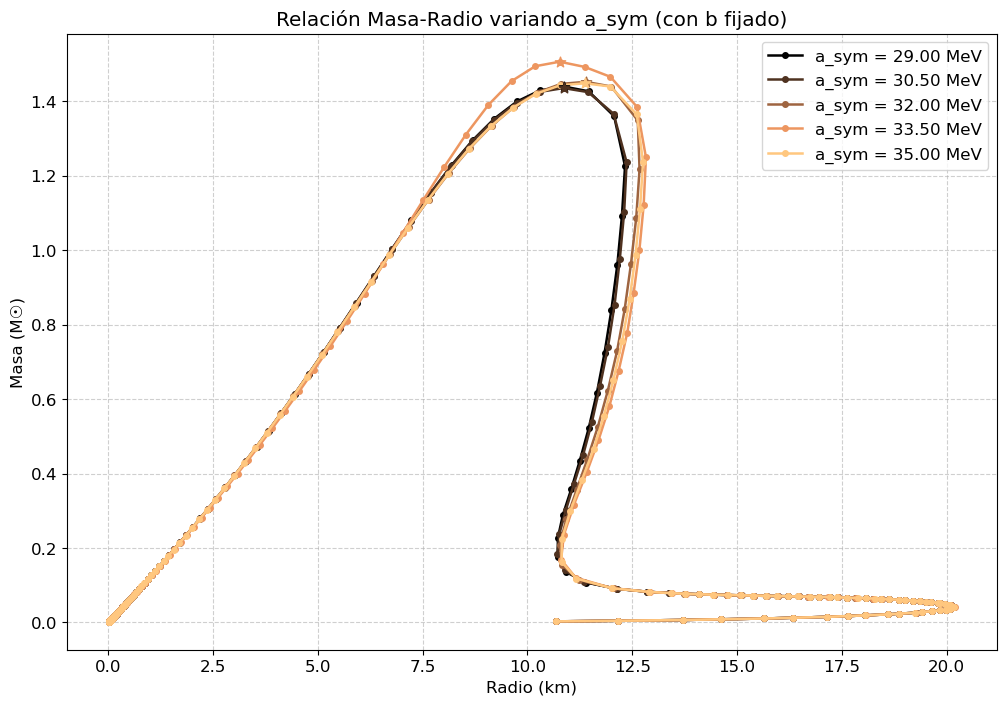

In [7]:
# Veamos que sucede cuando fiajmos b y variamos a_sym
param_fijado = 'b'
propiedad_estudio = 'a_sym'
valores_prop = np.linspace(29, 35, 5)

plt.figure(figsize=(12, 8))
colores = plt.cm.copper(np.linspace(0, 1, len(valores_prop)))

for i, prop_val in enumerate(valores_prop):
    print(f"Calculando para {propiedad_estudio} = {prop_val:.3f} con '{param_fijado}' fijado...")
    
    # Crear propiedades objetivo temporales
    props_temp = props_experimentales.copy()
    props_temp[propiedad_estudio] = prop_val
    
    # Calcular la relación masa-radio con el parámetro fijado
    masas, radios, _ = calcular_masa_radio_optimizado(
        props_temp,
        fixed_params=[param_fijado]  # Pasamos el parámetro a fijar como una lista
    )
    
    if masas is not None and radios is not None:
        # Graficar la curva M-R
        plt.plot(radios, masas, "o-", color=colores[i], linewidth=1.8, markersize=4, 
                 label=f'{propiedad_estudio} = {prop_val:.2f} MeV')
        
        # Marcar la masa máxima
        masa_max_idx = np.argmax(masas)
        plt.scatter(radios[masa_max_idx], masas[masa_max_idx], 
                    color=colores[i], s=60, marker='*', zorder=5)
    else:
        print(f"  Cálculo fallido para {propiedad_estudio} = {prop_val}")

# Configurar y mostrar el gráfico
plt.xlabel('Radio (km)')
plt.ylabel('Masa (M☉)')
plt.title(f'Relación Masa-Radio variando {propiedad_estudio} (con {param_fijado} fijado)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()